In [16]:
###### by A. Zdonek

### Generational Divergence - JetBrains Developer Ecosystem Survey - Data professionals using Python as their main language

#### How do different generations of Data proffesionals differ in:

* AI replacement anxiety?
* Ethical concerns?

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

### 1. Loading the data from our last notebook where we explored the data set

In [18]:
jetbrains_data = pd.read_csv('data/jetbrains_ai_health.csv', sep=',', dtype='unicode')

### 2. Funtions for analysis

In [19]:
class GenerationalDivergenceAnalysis:
    def __init__(self, df):
        self.df = df.copy()
        self.results = {}
        
        self.frequency_map = {
            'Always': 5,
            'Often': 4,
            'Sometimes': 3,
            'Rarely': 2,
            'Never': 1
        }
        
    def is_binary_column(self, col):
        unique_vals = self.df[col].dropna().unique()
        return len(unique_vals) == 1
    
    def convert_binary_to_bool(self, col):
        return self.df[col].notna().astype(int)
    
    def convert_ordinal_to_numeric(self, col):
        return self.df[col].map(self.frequency_map)
    
    def weighted_proportion_binary(self, col, group_col='age_range', weight_col='weight'):
        results = {}
        binary_series = self.convert_binary_to_bool(col)
        
        for group in sorted(self.df[group_col].dropna().unique()):
            mask = self.df[group_col] == group
            group_data = self.df[mask]
            
            if len(group_data) > 0:
                positive = (binary_series[mask] * group_data[weight_col]).sum()
                total = group_data[weight_col].sum()
                results[group] = (positive / total * 100) if total > 0 else 0
        
        return results
    
    def weighted_mean_ordinal(self, col, group_col='age_range', weight_col='weight'):
        results = {}
        
        numeric_series = self.convert_ordinal_to_numeric(col)
        
        for group in sorted(self.df[group_col].dropna().unique()):
            mask = self.df[group_col] == group
            group_data = self.df[mask]
            valid_mask = mask & numeric_series.notna()
            
            if valid_mask.sum() > 0:
                weighted_sum = (numeric_series[valid_mask] * self.df.loc[valid_mask, weight_col]).sum()
                weight_sum = self.df.loc[valid_mask, weight_col].sum()
                results[group] = weighted_sum / weight_sum if weight_sum > 0 else 0
        
        return results
    
    def weighted_proportion_ordinal_high(self, col, group_col='age_range', weight_col='weight', 
                                         threshold=['Often', 'Always']):
        results = {}
        
        for group in sorted(self.df[group_col].dropna().unique()):
            mask = self.df[group_col] == group
            group_data = self.df[mask]
            high_freq = group_data[col].isin(threshold)
            
            if len(group_data) > 0:
                positive = (high_freq * group_data[weight_col]).sum()
                total = group_data[weight_col].sum()
                results[group] = (positive / total * 100) if total > 0 else 0
        
        return results
    
    def analyze_ai_replacement_anxiety(self):
        print("=" * 80)
        print("1. AI Replacement Anxiety by Generation")
        print("=" * 80)
        
        anxiety_col = 'selfmon_problems::I feel anxious that AI advancements might eventually replace my role as a developer'
        
        if anxiety_col not in self.df.columns:
            print("Anxiety column not found in dataset")
            return
        
        anxiety_by_gen = self.weighted_proportion_ordinal_high(anxiety_col)
        
        print("\n AI Replacement Anxiety by Generation (Often/Always):")
        for gen, pct in sorted(anxiety_by_gen.items()):
            print(f"  {gen}: {pct:.1f}%")
        
        print("\n AI Replacement Anxiety Intensity (1-5 scale):")
        intensity_by_gen = self.weighted_mean_ordinal(anxiety_col)
        for gen, score in sorted(intensity_by_gen.items()):
            print(f"  {gen}: {score:.2f}/5")
        
        ai_cols = [col for col in self.df.columns if col.startswith('ai_llms_use_coding_at_work::')]
        ai_usage_matrix = pd.DataFrame()
        for col in ai_cols:
            ai_usage_matrix[col] = self.convert_binary_to_bool(col)
        
        self.df['ai_model_count'] = ai_usage_matrix.sum(axis=1)
        
        self.df['ai_usage_level'] = pd.cut(
            self.df['ai_model_count'], 
            bins=[-1, 0, 2, 4, 100],
            labels=['None', 'Low (1-2)', 'Medium (3-4)', 'High (5+)']
        )
        
        self.results['ai_anxiety'] = anxiety_by_gen
        
    def analyze_ethical_concerns(self):
        print("\n" + "=" * 80)
        print("2. Ethical Concerns")
        print("=" * 80)
        
        existential_col = 'ethical_concerns_ai::Existential risks (e.g. AI surpassing human intelligence)'
        
        immediate_cols = [
            'ethical_concerns_ai::Bias and discrimination',
            'ethical_concerns_ai::Privacy violations',
            'ethical_concerns_ai::Job displacement',
            'ethical_concerns_ai::Copyright violations'
        ]
        
        print("\n Existential Risk Concern by Generation:")
        existential_by_gen = self.weighted_proportion_binary(existential_col)
        for gen, pct in sorted(existential_by_gen.items()):
            print(f"  {gen}: {pct:.1f}%")
        
        print("\n Immediate Harms Concern by Generation:")
        immediate_by_gen = {}
        
        for gen in sorted(self.df['age_range'].dropna().unique()):
            mask = self.df['age_range'] == gen
            group_data = self.df[mask]
            
            has_immediate_concern = pd.Series(False, index=group_data.index)
            for col in immediate_cols:
                has_immediate_concern |= group_data[col].notna()
            
            positive = (has_immediate_concern * group_data['weight']).sum()
            total = group_data['weight'].sum()
            immediate_by_gen[gen] = (positive / total * 100) if total > 0 else 0
        
        for gen, pct in sorted(immediate_by_gen.items()):
            print(f"  {gen}: {pct:.1f}%")
        
        print("\n Detailed Ethical Concerns by Generation:")
        concern_cols = [col for col in self.df.columns if col.startswith('ethical_concerns_ai::')]
        
        for gen in sorted(self.df['age_range'].dropna().unique()):
            print(f"\n  {gen}:")
            gen_concerns = {}
            for col in concern_cols:
                concern_name = col.replace('ethical_concerns_ai::', '')
                if concern_name not in ['Other', 'None, I don\'t see any significant ethical concerns']:
                    pct = self.weighted_proportion_binary(col).get(gen, 0)
                    gen_concerns[concern_name] = pct
            
            top_concerns = sorted(gen_concerns.items(), key=lambda x: x[1], reverse=True)[:3]
            for concern, pct in top_concerns:
                print(f"    • {concern}: {pct:.1f}%")
        
        self.results['ethical_concerns'] = {
            'existential': existential_by_gen,
            'immediate': immediate_by_gen
        }

        
    def create_visualizations(self):
        sns.set_style("whitegrid")
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        fig.suptitle('Generational Divergence in AI Attitudes and Ethical Concerns', 
                     fontsize=16, fontweight='bold')
        
        if 'ai_anxiety' in self.results:
            ax = axes[0]
            data = self.results['ai_anxiety']
            generations = sorted(data.keys())
            values = [data[g] for g in generations]
            
            bars = ax.bar(range(len(generations)), values, color='steelblue', alpha=0.7)
            ax.set_xlabel('Generation', fontweight='bold')
            ax.set_ylabel('% Experiencing Anxiety (Often/Always)', fontweight='bold')
            ax.set_title('AI Replacement Anxiety by Generation')
            ax.set_xticks(range(len(generations)))
            ax.set_xticklabels(generations, rotation=45, ha='right')
            ax.set_ylim(0, max(values) * 1.2 if values else 10)
            
            for i, (bar, val) in enumerate(zip(bars, values)):
                ax.text(i, val + 1, f'{val:.1f}%', ha='center', va='bottom')
        
        if 'ethical_concerns' in self.results:
            ax = axes[1]
            existential = self.results['ethical_concerns']['existential']
            immediate = self.results['ethical_concerns']['immediate']
            generations = sorted(existential.keys())
            
            x = np.arange(len(generations))
            width = 0.35
            
            ax.bar(x - width/2, [existential[g] for g in generations], 
                   width, label='Existential Risks', color='darkred', alpha=0.7)
            ax.bar(x + width/2, [immediate[g] for g in generations], 
                   width, label='Immediate Harms', color='darkorange', alpha=0.7)
            
            ax.set_xlabel('Generation', fontweight='bold')
            ax.set_ylabel('% Concerned', fontweight='bold')
            ax.set_title('Types of Ethical Concerns by Generation')
            ax.set_xticks(x)
            ax.set_xticklabels(generations, rotation=45, ha='right')
            ax.legend()
        
        plt.tight_layout()
        return fig
    
    def run_full_analysis(self):
        """Run all analyses"""
        self.analyze_ai_replacement_anxiety()
        self.analyze_ethical_concerns()
        
        print("\n" + "=" * 80)
        print("ANALYSIS COMPLETE")
        print("=" * 80)

    def bar_charts(self):
        return self.create_visualizations()

In [20]:
class Charts:
    def __init__(self, obj):
        if not isinstance(obj, GenerationalDivergenceAnalysis):
            raise TypeError(f"Expected GenerationalDivergenceAnalysis, got {type(square).__name__}")
        self.df_results = obj.results.copy()
    def charts(self):
        sns.set_style("whitegrid")
        sns.set_palette("husl")
                
        generations = list(self.df_results['ai_anxiety'].keys())
        anxiety_vals = list(self.df_results['ai_anxiety'].values())
        existential_vals = list(self.df_results['ethical_concerns']['existential'].values())
        immediate_vals = list(self.df_results['ethical_concerns']['immediate'].values())
        
        fig = plt.figure(figsize=(20, 12))
        fig.suptitle('AI Anxiety & Ethical Concerns: Generational Analysis', fontsize=24, fontweight='bold', y=0.98)
        
        # 1. The Generation Gap Story
        ax1 = plt.subplot(2, 2, 1)
        y_pos = np.arange(len(generations))
        
        anxious = anxiety_vals
        not_anxious = [-100 + a for a in anxious]
        
        bars1 = ax1.barh(y_pos, not_anxious, color='#8AFF9B', alpha=0.7, label='Not Anxious')
        bars2 = ax1.barh(y_pos, anxious, color='#FF0000', alpha=0.8, label='Anxious')
        
        for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
            if anxious[i] > 0:
                ax1.text(anxious[i]/2, i, f'{anxious[i]:.1f}%', 
                        ha='center', va='center', fontweight='bold', fontsize=10)
            ax1.text(-50, i, f'{100-anxious[i]:.1f}%', 
                    ha='center', va='center', fontweight='bold', fontsize=10, color='#2d5016')
        
        ax1.set_yticks(y_pos)
        ax1.set_yticklabels(generations, fontsize=11, fontweight='bold')
        ax1.set_xlabel('Percentage (%)', fontsize=12, fontweight='bold')
        ax1.set_title('The Generation Gap: AI Replacement Anxiety', 
                     fontsize=14, fontweight='bold', pad=15)
        ax1.axvline(x=0, color='black', linewidth=1.5)
        ax1.set_xlim(-100, 35)
        ax1.legend(loc='lower right', fontsize=10)
        ax1.grid(axis='x', alpha=0.3)
        
        # 2. Anxiety vs Ethical Concerns
        ax2 = plt.subplot(2, 2, 2)
        ax2_twin = ax2.twinx()
        
        x = np.arange(len(generations))
        
        line1 = ax2.plot(x, anxiety_vals, 'o-', color='#F4A8FF', linewidth=3, 
                        markersize=10, label='Job Anxiety', alpha=0.8)
        ax2.fill_between(x, anxiety_vals, alpha=0.2, color='#F4A8FF')
        
        line2 = ax2_twin.plot(x, existential_vals, 's--', color='#F6339A', linewidth=2.5, 
                             markersize=8, label='Existential Risk', alpha=0.8)
        line3 = ax2_twin.plot(x, immediate_vals, '^--', color='#FE9A37', linewidth=2.5, 
                             markersize=8, label='Immediate Harms', alpha=0.8)
        
        ax2.set_xlabel('Generation', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Job Anxiety (%)', fontsize=12, fontweight='bold', color='#F4A8FF')
        ax2_twin.set_ylabel('Ethical Concerns (%)', fontsize=12, fontweight='bold')
        ax2.set_xticks(x)
        ax2.set_xticklabels(generations, rotation=45, ha='right', fontsize=10)
        ax2.tick_params(axis='y', labelcolor='#F4A8FF')
        ax2.set_title('The Disconnect: Anxiety vs Ethical Concerns', 
                     fontsize=14, fontweight='bold', pad=15)
        ax2.set_ylim(-2, 32)
        ax2_twin.set_ylim(-2, 45)
        
        lines = line1 + line2 + line3
        labels = [l.get_label() for l in lines]
        ax2.legend(lines, labels, loc='upper left', fontsize=10)
        ax2.grid(True, alpha=0.3)
        
        # 3. Ethical Concerns Matrix
        ax3 = plt.subplot(2, 2, 3)
        heatmap_data = np.array([existential_vals, immediate_vals])
        
        im = ax3.imshow(heatmap_data, cmap='YlOrRd', aspect='auto', vmin=0, vmax=40)
        
        cbar = plt.colorbar(im, ax=ax3)
        cbar.set_label('Concern Level (%)', rotation=270, labelpad=20, fontweight='bold')
        
        ax3.set_xticks(np.arange(len(generations)))
        ax3.set_yticks(np.arange(2))
        ax3.set_xticklabels(generations, rotation=45, ha='right', fontsize=10)
        ax3.set_yticklabels(['Existential Risk', 'Immediate Harms'], fontsize=11, fontweight='bold')
        
        for i in range(2):
            for j in range(len(generations)):
                text = ax3.text(j, i, f'{heatmap_data[i, j]:.1f}%',
                               ha="center", va="center", color="black" if heatmap_data[i, j] < 25 else "white",
                               fontweight='bold', fontsize=10)
        
        ax3.set_title('Ethical Concerns Heatmap by Generation', 
                     fontsize=14, fontweight='bold', pad=15)
        
        # 4. The Fear Spectrum
        ax4 = plt.subplot(2, 2, 4)
        
        x = np.arange(len(generations))
        
        ax4.fill_between(x, 0, existential_vals, alpha=0.7, color='#9B59B6', label='Existential Risk')
        ax4.fill_between(x, existential_vals, 
                        [e + i for e, i in zip(existential_vals, immediate_vals)], 
                        alpha=0.7, color='#E67E22', label='Immediate Harms')
        
        total_concerns = [e + i for e, i in zip(existential_vals, immediate_vals)]
        ax4.plot(x, total_concerns, 'o-', color='#2C3E50', linewidth=2, 
                markersize=8, label='Total Concerns', alpha=0.9)
        
        ax4.set_xlabel('Generation', fontsize=12, fontweight='bold')
        ax4.set_ylabel('Concern Level (%)', fontsize=12, fontweight='bold')
        ax4.set_xticks(x)
        ax4.set_xticklabels(generations, rotation=45, ha='right', fontsize=10)
        ax4.set_title('The Fear Spectrum: Stacked Ethical Concerns', 
                     fontsize=14, fontweight='bold', pad=15)
        ax4.legend(loc='upper left', fontsize=10)
        ax4.grid(True, alpha=0.3, axis='y')
        ax4.set_ylim(0, 65)
        
        plt.tight_layout()
        plt.show()

        ##########################
        
        print("\n" + "="*80)
        print("Key insights")
        print("="*80)
        print("\n Age range 40-49 paradox:")
        print(f"   • Highest job anxiety: {anxiety_vals[5]:.1f}%")
        print(f"   • Immediate concerns: {immediate_vals[5]:.1f}%")
        print("   • Mid-career professionals feel most worried")
        
        print("\n Age range (21-24) paradox:")
        print(f"   • Job anxiety: {anxiety_vals[1]:.1f}%")
        print(f"   • Existential risk concern: {existential_vals[1]:.1f}%")
        print("   • Young professionals fear AI but not job loss")
        
        print("\n Age range 50-59 bimodal response:")
        print(f"   • Anxiety when present: 5.0/5 (highest intensity)")
        print(f"   • But 24.4% report NO ethical concerns at all")
        print("   • Individuals are either deeply worried or completely unconcerned")
        
        print("\n Peak concerns:")
        print(f"   • Highest immediate harms: 50-59 at {immediate_vals[6]:.1f}%")
        print(f"   • Highest existential: 25-29 at {existential_vals[2]:.1f}%")
        print(f"   • Total concern peak: 25-29 at {existential_vals[2] + immediate_vals[2]:.1f}%")
        
        print("\n" + "="*80)

### 3. Analysis

In [21]:
df = pd.read_csv('data/jetbrains_ai_health.csv')
analyzer = GenerationalDivergenceAnalysis(df)
analyzer.run_full_analysis()

1. AI Replacement Anxiety by Generation

 AI Replacement Anxiety by Generation (Often/Always):
  18–20: 0.0%
  21–24: 0.0%
  25–29: 1.4%
  30–34: 7.2%
  35–39: 6.4%
  40–49: 27.8%
  50–59: 6.8%

 AI Replacement Anxiety Intensity (1-5 scale):
  21–24: 1.70/5
  25–29: 1.78/5
  30–34: 2.75/5
  35–39: 2.81/5
  40–49: 3.61/5
  50–59: 5.00/5

2. Ethical Concerns

 Existential Risk Concern by Generation:
  18–20: 0.0%
  21–24: 8.1%
  25–29: 21.9%
  30–34: 0.5%
  35–39: 1.7%
  40–49: 6.4%
  50–59: 0.0%

 Immediate Harms Concern by Generation:
  18–20: 0.0%
  21–24: 21.1%
  25–29: 34.3%
  30–34: 26.8%
  35–39: 21.7%
  40–49: 26.4%
  50–59: 39.2%

 Detailed Ethical Concerns by Generation:

  18–20:
    • Bias and discrimination: 0.0%
    • Copyright violations: 0.0%
    • Existential risks (e.g. AI surpassing human intelligence): 0.0%

  21–24:
    • Potential for misuse (e.g. autonomous weapons): 23.6%
    • Privacy violations: 18.6%
    • Bias and discrimination: 13.0%

  25–29:
    • Job disp

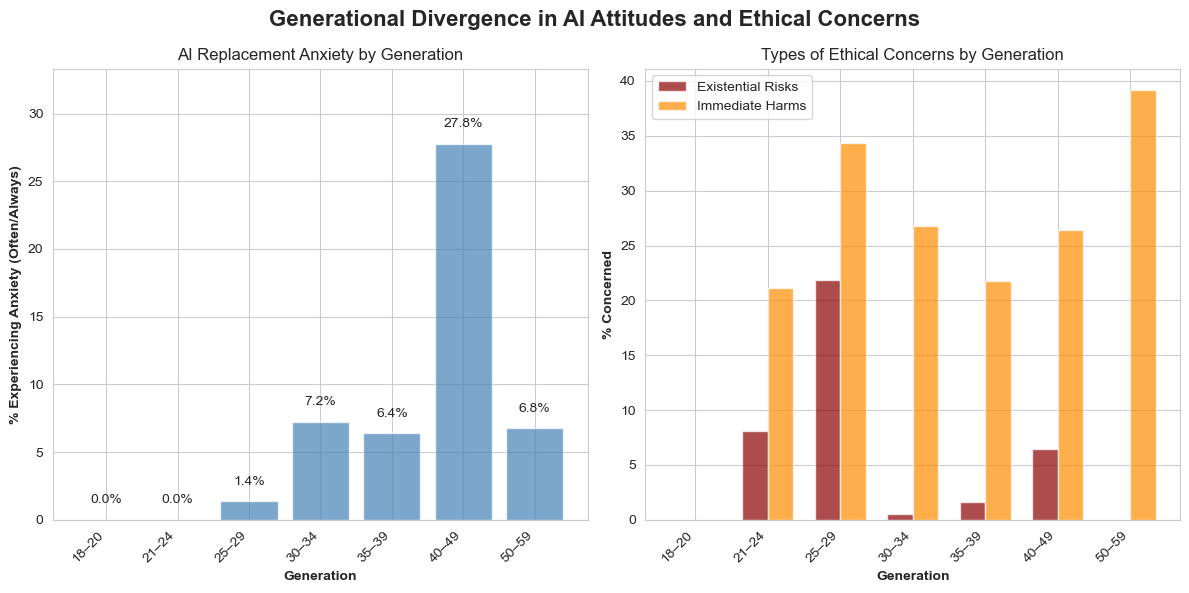

In [22]:
fig = analyzer.bar_charts()
plt.show()

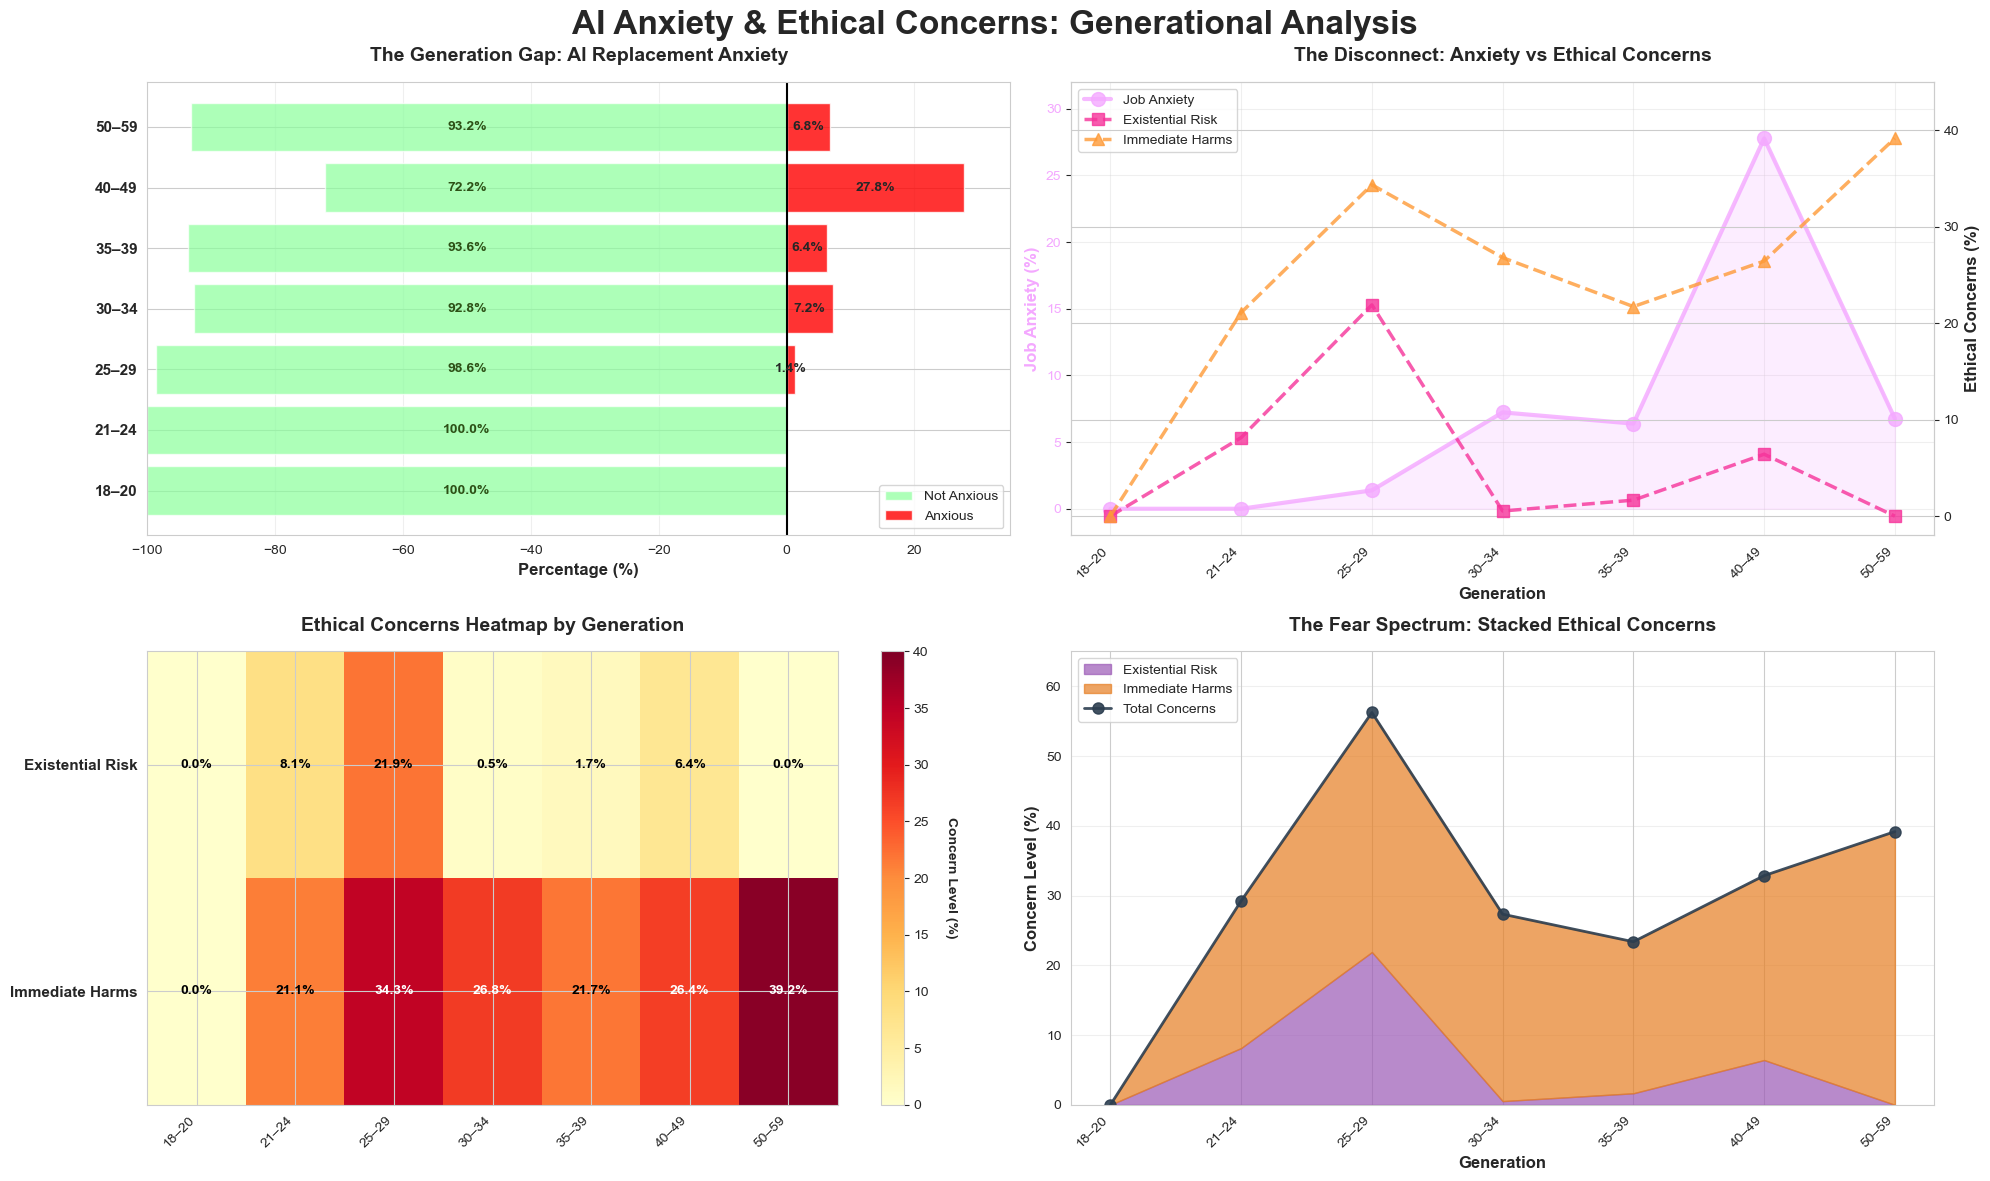


Key insights

 Age range 40-49 paradox:
   • Highest job anxiety: 27.8%
   • Immediate concerns: 26.4%
   • Mid-career professionals feel most worried

 Age range (21-24) paradox:
   • Job anxiety: 0.0%
   • Existential risk concern: 8.1%
   • Young professionals fear AI but not job loss

 Age range 50-59 bimodal response:
   • Anxiety when present: 5.0/5 (highest intensity)
   • But 24.4% report NO ethical concerns at all
   • Individuals are either deeply worried or completely unconcerned

 Peak concerns:
   • Highest immediate harms: 50-59 at 39.2%
   • Highest existential: 25-29 at 21.9%
   • Total concern peak: 25-29 at 56.2%



In [23]:
charts = Charts(analyzer)
charts.charts()